In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from six.moves import cPickle as pickle
from six.moves import range

In [4]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    test_dataset = save['test_data']
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    del save
    
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (73401, 32, 32, 1) (73401, 6)
Validation set (10000, 32, 32, 1) (10000, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [5]:
train_labels[0]

array([ 2,  5,  1, 10, 10, 10])

In [6]:
test_labels[:]

array([[ 3,  2,  7,  3, 10, 10],
       [ 3,  2,  6,  6, 10, 10],
       [ 2,  5,  6, 10, 10, 10],
       ..., 
       [ 1,  2, 10, 10, 10, 10],
       [ 2,  5,  8, 10, 10, 10],
       [ 2,  2,  4, 10, 10, 10]])

In [7]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

In [8]:
def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [9]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.subtract(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

In [10]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [11]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
shape = [batch_size, image_size, image_size, num_channels]
shape[3]

1

In [12]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
depth3 = 128
num_hidden1 = 512
num_hidden2 = 128
num_hidden3 = 32
shape = [batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 32 x 32 x 11, filter size: 5 x 5 x 1 x 32
# P2: pooling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, filter size: 5 x 5 x 16 x 64
# P4: pooling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, filter size: 5 x 5 x 32 x 128
# Dropout
# F6: fully-connected layer, weight size: 64 x 11
# Output layer, weight size: 16 x 10

train_size = train_labels.shape[0]

graph = tf.Graph()
with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    #tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w1 = tf.get_variable("WS11", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS11')
    
    s2_w1 = tf.get_variable("WS12", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS12')
    
    s3_w1 = tf.get_variable("WS13", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS13')
    
    s4_w1 = tf.get_variable("WS14", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS14')
    
    s5_w1 = tf.get_variable("WS15", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS15')
    

    s1_w2 = tf.get_variable("WS21", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS21')
    
    s2_w2 = tf.get_variable("WS22", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS22')
    
    s3_w2 = tf.get_variable("WS23", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS23')
    
    s4_w2 = tf.get_variable("WS24", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS24')
    
    s5_w2 = tf.get_variable("WS25", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS25')
    

    s1_w3 = tf.get_variable("WS31", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS31')
    
    s2_w3 = tf.get_variable("WS32", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS32')
    
    s3_w3 = tf.get_variable("WS33", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS33')
    
    s4_w3 = tf.get_variable("WS34", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS34')
    
    s5_w3 = tf.get_variable("WS35", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS35')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        print ("shape is: ", shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        print("after reshape: ", reshape.get_shape())
        # hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        hidden11 = tf.nn.relu(tf.matmul(reshape, s1_w1) + s1_b1)
        hidden21 = tf.nn.relu(tf.matmul(reshape, s2_w1) + s2_b1)
        hidden31 = tf.nn.relu(tf.matmul(reshape, s3_w1) + s3_b1)
        hidden41 = tf.nn.relu(tf.matmul(reshape, s4_w1) + s4_b1)
        hidden51 = tf.nn.relu(tf.matmul(reshape, s5_w1) + s5_b1)
        
        print ("hidden11 shape: ", hidden11.shape)
        
        hidden12 = tf.nn.relu(tf.matmul(hidden11, s1_w2) + s1_b2)
        hidden22 = tf.nn.relu(tf.matmul(hidden21, s2_w2) + s2_b2)
        hidden32 = tf.nn.relu(tf.matmul(hidden31, s3_w2) + s3_b2)
        hidden42 = tf.nn.relu(tf.matmul(hidden41, s4_w2) + s4_b2)
        hidden52 = tf.nn.relu(tf.matmul(hidden51, s5_w2) + s5_b2)
        
        print ("hidden12 shape: ", hidden12.shape)
        
        logits1 = tf.matmul(hidden12, s1_w3) + s1_b3
        logits2 = tf.matmul(hidden22, s2_w3) + s2_b3
        logits3 = tf.matmul(hidden32, s3_w3) + s3_b3
        logits4 = tf.matmul(hidden42, s4_w3) + s4_b3
        logits5 = tf.matmul(hidden52, s5_w3) + s5_b3
        
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.6, shape)
    print ("logits1 shape: ",logits1.shape)
    print (logits1[0])
    print (tf_train_labels[:,1][0])
    print (logits2.shape)
    print (logits3.shape)
    print (logits4.shape)
    print (logits5.shape)
    
    # L2 regularization for the fully connected parameters.
    regularizers = [(tf.nn.l2_loss(s1_w2) + tf.nn.l2_loss(s1_b2)),
                    (tf.nn.l2_loss(s2_w2) + tf.nn.l2_loss(s2_b2)),
                    (tf.nn.l2_loss(s3_w2) + tf.nn.l2_loss(s3_b2)),
                    (tf.nn.l2_loss(s4_w2) + tf.nn.l2_loss(s4_b2)),
                    (tf.nn.l2_loss(s5_w2) + tf.nn.l2_loss(s5_b2)),]
    
    post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))]
    
    loss = (post_logits[0] + 4e-4 * regularizers[0]) + (post_logits[1] + 4e-4 * regularizers[1]) + \
           (post_logits[2] + 4e-4 * regularizers[2]) + (post_logits[3] + 4e-4 * regularizers[3]) + \
           (post_logits[4] + 4e-4 * regularizers[4])
    
    # Optimizer.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.stack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3]),\
                                tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.stack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3]),\
                                tf.nn.softmax(valid_logits[4])])
    
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.stack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),\
                               tf.nn.softmax(test_logits[4])])
    final_test_prediction = tf.transpose(tf.argmax(test_prediction, 2))

    saver = tf.train.Saver()

shape is:  [64, 1, 1, 512]
after reshape:  (64, 512)
hidden11 shape:  (64, 128)
hidden12 shape:  (64, 32)
logits1 shape:  (64, 11)
Tensor("strided_slice:0", shape=(11,), dtype=float32)
Tensor("strided_slice_2:0", shape=(), dtype=int32)
(64, 11)
(64, 11)
(64, 11)
(64, 11)
shape is:  [64, 1, 1, 512]
after reshape:  (64, 512)
hidden11 shape:  (64, 128)
hidden12 shape:  (64, 32)
shape is:  [10000, 1, 1, 512]
after reshape:  (10000, 512)
hidden11 shape:  (10000, 128)
hidden12 shape:  (10000, 32)
shape is:  [13068, 1, 1, 512]
after reshape:  (13068, 512)
hidden11 shape:  (13068, 128)
hidden12 shape:  (13068, 32)


In [13]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [ ]:
num_steps = 25001
#num_steps = 4000

loss_values = []
train_accuracies = []
validation_accuracies = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()  
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        #print ("prediction shape: ", predictions.shape)
        #print ("first prediction: ", predictions[:,0:1,:])
        #print ("label is: ", test_labels[:,1:6][0])
        #print ("prediction is: ", np.argmax(predictions[:,0:1,:], 2).T)
        
    
        #if step % 10 == 0:
        #    loss_values.append(l)
            
        if (step % 1000 == 0): 
            train_accuracy = accuracy(predictions, batch_labels[:,1:6])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(valid_accuracy)
            
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    print ('Prediction is: ', final_test_prediction.eval()[1:11])
    #print ("label is: ", test_labels[:,0:6])
    #print ("prediction is: ", np.argmax(test_prediction.eval(), 2).T)
    
    save_path = saver.save(session, "cnn.convnet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 27.938633
Minibatch accuracy: 4.4%
Validation accuracy: 51.3%
Minibatch loss at step 1000: 6.066948
Minibatch accuracy: 61.9%
Validation accuracy: 58.8%
Minibatch loss at step 2000: 3.158970
Minibatch accuracy: 83.1%
Validation accuracy: 80.5%
Minibatch loss at step 3000: 1.887466
Minibatch accuracy: 90.6%
Validation accuracy: 88.5%
Minibatch loss at step 4000: 1.991202
Minibatch accuracy: 90.6%
Validation accuracy: 91.4%
Minibatch loss at step 5000: 0.771854
Minibatch accuracy: 96.9%
Validation accuracy: 92.8%
Minibatch loss at step 6000: 1.410333
Minibatch accuracy: 93.4%
Validation accuracy: 93.6%
Minibatch loss at step 7000: 1.296645
Minibatch accuracy: 95.0%
Validation accuracy: 94.4%
Minibatch loss at step 8000: 0.887557
Minibatch accuracy: 95.9%
Validation accuracy: 94.8%
Minibatch loss at step 9000: 0.814390
Minibatch accuracy: 97.8%
Validation accuracy: 94.8%
Minibatch loss at step 10000: 0.780427
Minibatch accuracy: 95.3%
Validation accur

In [14]:
print (test_labels[1:11,1:6])
#with tf.Session(graph=graph) as session:
#    print (final_test_prediction.eval())

[[ 2  6  6 10 10]
 [ 5  6 10 10 10]
 [ 3  1 10 10 10]
 [ 2  8 10 10 10]
 [ 7  5 10 10 10]
 [ 7 10 10 10 10]
 [ 9 10 10 10 10]
 [ 2  4  0 10 10]
 [ 2  2 10 10 10]
 [ 1 10 10 10 10]]


In [29]:
with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    saver = tf.train.import_meta_graph('./cnn.convnet.meta')    
    saver.restore(session, './cnn.convnet')
    print("Model restored.")  
    
    print('Initialized')
    tf_test_dataset_1 = tf.constant(test_dataset[1:10,:,:,:])
    test_logits_1 = model(tf_test_dataset_1, 1.0, shape)
    test_prediction_1 = tf.stack([tf.nn.softmax(test_logits_1[0]), tf.nn.softmax(test_logits_1[1]),\
                               tf.nn.softmax(test_logits_1[2]), tf.nn.softmax(test_logits_1[3]),\
                               tf.nn.softmax(test_logits_1[4])])
    final_test_prediction_1 = tf.transpose(tf.argmax(test_prediction_1, 2))
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #predict,test_prediction = session.run([predict,test_prediction], feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    print ('Prediction is: ', final_test_prediction.eval()[11:21])
    print ("new test dataset is: ", final_test_prediction.eval())
    #print(test_prediction)
    #print (predict)
    #print('Test accuracy: %.1f%%' % accuracy(predict, test_labels[im_samples,1:6]))
    

Model restored.
Initialized
shape is:  [9, 1, 1, 512]
after reshape:  (9, 512)
hidden11 shape:  (9, 128)
hidden12 shape:  (9, 32)
Prediction is:  [[ 2  2 10 10 10]
 [ 1  2  2 10 10]
 [ 2  7 10 10 10]
 [ 3  9 10 10 10]
 [ 1  2 10 10 10]
 [ 8  2 10 10 10]
 [ 2  2 10 10 10]
 [ 6  1 10 10 10]
 [ 2  4 10 10 10]
 [ 1  2 10 10 10]]
new test dataset is:  [[ 2  7  3 10 10]
 [ 2  6  6 10 10]
 [ 5  6 10 10 10]
 ..., 
 [ 2 10 10 10 10]
 [ 5  8 10 10 10]
 [ 2  4 10 10 10]]


ValueError: incompatible sizes: argument 'height' must be length 11 or scalar

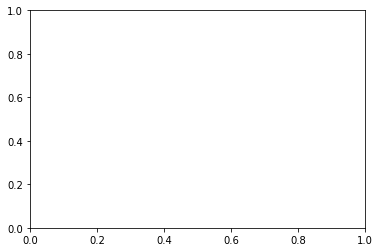

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)

plt.bar(np.arange(0,10001,10), loss_values, align='center')
plt.title('Dropout = 0.9375')
plt.xlabel('Training Step')
plt.yticks(np.arange(0,21,5))
plt.xticks(np.arange(0,10500,5000))
plt.ylabel('Loss Value')

plt.show()

In [66]:
print (len(train_accuracies))
print (len(validation_accuracies))

26
26


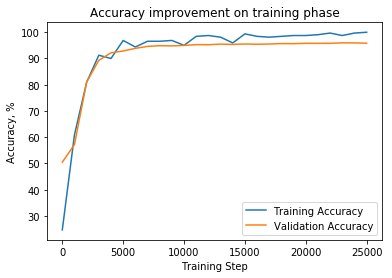

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(2)

plt.plot(np.arange(0,25001,1000), train_accuracies, label = 'Training Accuracy')
plt.plot(np.arange(0,25001,1000), validation_accuracies, label = 'Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Accuracy improvement on training phase')
plt.xlabel('Training Step')
plt.ylabel('Accuracy, %')

plt.show()

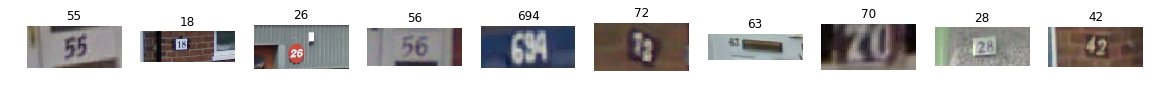

In [60]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
for i, item in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = test_filenames[item]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[item,0]):
        house_num += str(test_labels[item,k+1])
        
    im_samples.extend([item])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [61]:
with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    saver = tf.train.import_meta_graph('./cnn.convnet.meta')    
    saver.restore(session, './cnn.convnet')
    print("Model restored.")  
    
    print('Initialized')
    tf_test_dataset_1 = tf.constant(test_dataset[im_samples,:,:,:])
    test_logits_1 = model(tf_test_dataset_1, 1.0, shape)
    test_prediction_1 = tf.stack([tf.nn.softmax(test_logits_1[0]), tf.nn.softmax(test_logits_1[1]),\
                               tf.nn.softmax(test_logits_1[2]), tf.nn.softmax(test_logits_1[3]),\
                               tf.nn.softmax(test_logits_1[4])])
    final_test_prediction_1 = tf.transpose(tf.argmax(test_prediction_1, 2))
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #predict,test_prediction = session.run([predict,test_prediction], feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    #print ('Prediction is: ', final_test_prediction.eval()[11:21])
    final_test_prediction_1 = final_test_prediction_1.eval()
    #print ("new test prediction is: ", final_test_prediction_1)
    #print(test_prediction)
    #print (predict)
    #print('Test accuracy: %.1f%%' % accuracy(predict, test_labels[im_samples,1:6]))
    

Model restored.
Initialized
shape is:  [10, 1, 1, 512]
after reshape:  (10, 512)
hidden11 shape:  (10, 128)
hidden12 shape:  (10, 32)


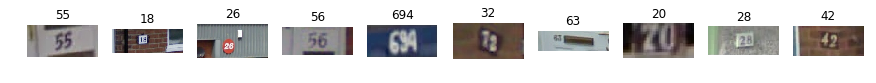

In [62]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = test_filenames[j]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(final_test_prediction_1[i,:] != 10)):
        house_num += str(final_test_prediction_1[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [59]:
test_labels[im_samples,1:6]

array([[ 5,  2, 10, 10, 10],
       [ 1, 10, 10, 10, 10],
       [ 2, 10, 10, 10, 10],
       [ 3,  6, 10, 10, 10],
       [ 5, 10, 10, 10, 10],
       [ 1,  0, 10, 10, 10],
       [ 7,  8,  8, 10, 10],
       [ 5, 10, 10, 10, 10],
       [ 4, 10, 10, 10, 10],
       [ 1,  4, 10, 10, 10]])

In [40]:
final_test_prediction_1[0,:] != 10

True

In [41]:
im_samples

[767, 1684, 6223, 6852, 6909, 7085, 10070, 10153, 11199, 11613]

In [54]:
np.arange(np.sum(final_test_prediction_1[5,:] != 10))

array([0, 1, 2])